# **Tarea 2**
## Machine Learning
### Kathryn Barraza - Estudiante de Ing. Civil Matemática UV


---



El siguiente trabajo está basado en
- La implementación vista en clases, realizada por el Profesor Alejandro Pereira, para los primeros modelos: regresión logística y svm.
- Más códigos que fueron extraídos de internet para los últimos modelos: Naïve Bayes, LDA y QDA.

# **Contenidos**

1.   Introducción
2.   Librerías
3.   Datos
4.   Test-Train split
5.   Regrisión Logísitca
6.   SVM
7.   Naïve Bayes
8.   LDA
9.   QDA
10.  Métricas de desempeño
11.  Tabla comparativa
12.  Conclusión



# **Introducción**

#### A través de una data de ataque al corazón se busca realizar comparaciones de modelos de aprendizaje supervisado, cuya variable respuesta es la chance que se tiene de sufrir un ataque al corazón.
#### Los datos fueron extraídos desde Kaggle.

### **Objetivo**

#### Implementar regresión logística, SVM, Naive Bayes, LDA y QDA, para realizar comparaciones entre ellos a través del uso de métricas de desempeño. Con el fin de observar qué modelo obtiene mejores resultados para este problema en particular.

# **Librerías**

Aquí importamos las librerías necesarias para la ejecución de este trabajo.

In [56]:
#librerías generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics
import seaborn as sns
#librerías específicas de los modelos
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
#librerías extras
from sklearn.model_selection import train_test_split
from scipy.special import expit
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc

#**Datos**

In [3]:
#Importamos los datos
from google.colab import drive
drive.mount('/content/drive')
url='/content/drive/MyDrive/data.csv'
df= pd.read_csv(url)
#Mostramos los primeros datos de todo nuestro conjunto
df.head()

Mounted at /content/drive


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


In [4]:
#Aquí arreglamos ciertas cosas con respecto a la data: renombramos, borramos lo que tiene datos perdidos y vemos al final con cuantos datos nos quedamos.
df.rename(columns = {'num       ': 'attack'}, inplace = True)
df.replace("?", np.nan, inplace = True)
df.drop(columns = ['slope', 'ca', 'thal'], inplace = True)
df.dropna(inplace= True)
df.shape

(261, 11)

### Variables que vamos a usar

    age: age in years
    sex: sex (1 = male; 0 = female)
    cp: chest pain type
    – 1: typical angina
    – 2: atypical angina
    – 3: non-anginal pain
    – 4: asymptomatic
    trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    chol: serum cholesterol in mg/dl
    fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    restecg: resting electrocardiographic results
    – 0: normal
    – 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    – 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria
    thalach: maximum heart rate achieved
    exang: exercise-induced angina (1 = yes; 0 = no)
    oldpeak: ST depression induced by exercise relative to rest

## **Test - Train split**

Hacemos la separación de nuestra muestra en datos de entrenamiento y datos de evaluación. Es útil hacer esto para evaluar los modelos una vez entrenados, pues queremos saber si ha aprendido adecuadamente del fragmento de datos de aprendizaje.

Esta separación se hará para los cinco modelos con el mismo tamaño de test 0.20 y semilla 123. Esto con el fin de que nuestras comparaciones finales sean más consecuentes.


In [5]:
random_seed = 123
df_train, df_test = train_test_split(df, test_size=0.20, random_state=random_seed, stratify=df['attack'])


print(df_train.shape) #tamaño de nuestros datos de entrenamiento
print(df_test.shape) #tamaño de nuestros datos de evaluación

print("\nPercentages of heart attacks in Train data:\n", df_train['attack'].value_counts(normalize=True))
print("\nPercentages of heart attacks in Test data:\n", df_test['attack'].value_counts(normalize=True))

(208, 11)
(53, 11)

Percentages of heart attacks in Train data:
 0    0.625
1    0.375
Name: attack, dtype: float64

Percentages of heart attacks in Test data:
 0    0.622642
1    0.377358
Name: attack, dtype: float64


In [6]:
#Separamos a las variables en dos grupos, numericas y categoricas
#Estandarización de variables numéricas para trabajar con el modelo de Regresión logística
## pues al intentar hacerlo sin reescalamiento había un aviso de problemas de convergencia, por lo que mejor estandarizamos en este caso

numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
cat_cols = list(set(df.columns) - set(numeric_cols) - {'attack'})
cat_cols.sort()

print("Numerical var:", numeric_cols)
print("\nCategorical var:", cat_cols)

scaler = StandardScaler()
scaler.fit(df_train[numeric_cols])

def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    X_categorical = df[cat_cols].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = df['attack']
    return X, y

X, y = get_features_and_target_arrays(df_train, numeric_cols, cat_cols, scaler)

Numerical var: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

Categorical var: ['cp', 'exang', 'fbs', 'restecg', 'sex']


# **Regresión Logística**
La regresión logística es un modelo de regresión supervisado que modela la probabilidad. Es una técnica de análisis de datos para encontrar las relaciones entre dos factores de datos. Luego, utiliza esta relación para predecir el valor de uno de esos factores basándose en el otro.

---



In [7]:
log = LogisticRegression()

log.fit(X, y)

LogisticRegression()

Evaluamos el modelo:

In [9]:
X_test_log, y_test_log = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

In [10]:
y_score_log = log.decision_function(X_test_log)

Curva ROC de Regresión logística:

Text(0.5, 1.0, 'Roc de Regresión Logística + random guessing')

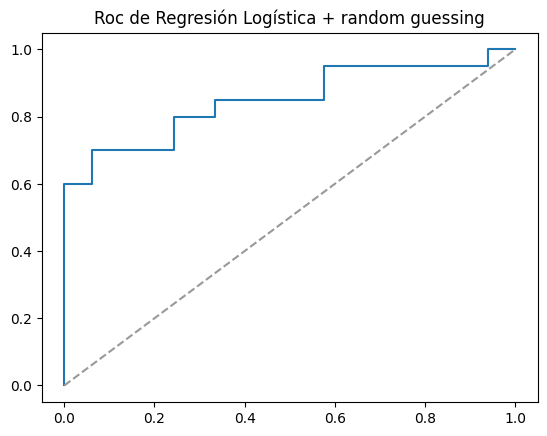

In [12]:
fpr_log, tpr_log, _ = sk_metrics.roc_curve(y_test_log, y_score_log, pos_label= log.classes_[1])
roc_auc_log = sk_metrics.auc(fpr_log,tpr_log)
plt.plot(fpr_log, tpr_log, label="ROC fold (area=%0.2f)"%(roc_auc_log))
plt.plot([0,1],[0,1],linestyle="--",color=(0.6,0.6,0.6),label="random guessing")
plt.title('Roc de Regresión Logística + random guessing')

Vemos que el modelo de regresión logística ajusta mejor que nuestra línea punteada gris, que representa el "random guessing", que sería equivalente a un simple experimento como lanzar una moneda, con probabilidad 1/2 de salir cara y 1/2 de salir sello.

Nos interesa esta comparación, pues en el caso de que los dos modelos ajusten similar, preferentemente eligiremos el más simple. En este caso vemos que la curva roc de nuestro modelo está más cerca del 1 que el "random guessing", por lo que nos inclinariamos más por él.

Valor AUC:

In [23]:
# Primero definimos una función de truncamiento para el valor AUC de regresión logística y los próximos modelo,
# pues nos entregan muchos decimales que no nos aportan nueva información (ya que muchos de ellos eran periódicos).
# Tomaremos 3 cifras decimales significantes.

def trunc(num, n):
    integer = int(num * (10**n))/(10**n)
    return float(integer)

In [46]:
print(trunc(roc_auc_log,3))

0.848


Aquí vemos el valor del AUC, que es de un porcentaje de 84,8%.

Sabemos que mientras más alto valor tiene el AUC de un modelo, este es mejor; donde el máximo es 1. Esto siempre que nos estemos enfocando en esta medida para comparar modelos, ya que sabemos que hay muchas más, para poder decidir realmente qué modelo es más apropiado para un problema).

Ahora en nuestro caso el AUC del modelo de regresión logística nos está dando un buen valor para considerar en nuestras conclusiones finales.

# **SVM**
El modelo SVM se puede definir como un conjunto de algoritmos de aprendizaje supervisado. Por ejemplo, dado un conjunto de muestras de entrenamiento, podemos etiquetar las clases y entrenar con ellas un modelo SVM, que nos servirá para predecir la clase de una nueva muestra.

---



In [27]:
y = df["attack"]
X = df.drop('attack',axis=1)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.20, random_state = 123, stratify=df['attack'])

Evaluamos el modelo:

In [28]:
svc =  svm.SVC(kernel='linear', C=1)
svc.fit(X_train_svm, y_train_svm)

svc_predicted = svc.predict(X_test_svm)

In [29]:
y_score_svm = svc.decision_function(X_test_svm.to_numpy())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Curva ROC:

Text(0.5, 1.0, 'Roc de SVM + random guessing')

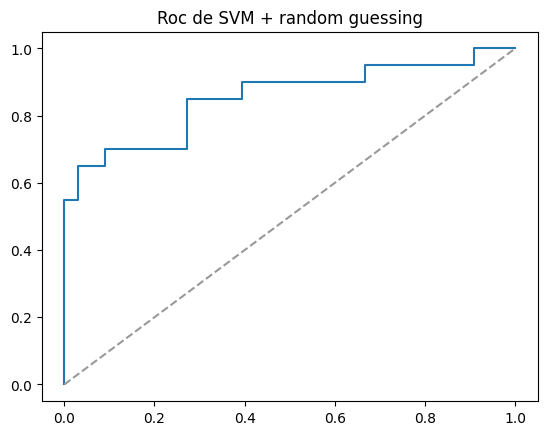

In [30]:
fpr_svm, tpr_svm, _ = sk_metrics.roc_curve(y_test_svm, y_score_svm)
roc_auc_svm=sk_metrics.auc(fpr_svm,tpr_svm)
plt.plot(fpr_svm, tpr_svm, label="ROC fold (area=%0.2f)"%(roc_auc_svm))
plt.plot([0,1],[0,1],linestyle="--",color=(0.6,0.6,0.6),label="random guessing")
plt.title('Roc de SVM + random guessing')

Notamos que la curva Roc supera el "random guessing" y además como se acerca al 1, podríamos preferir el modelo SVM sobre el experimento aleatorio, pero más adelante haremos la comparación entre modelos, ya que no deberíamos tomar una preferencia sin considerar más medidas comparativas.

Valor AUC de SVM:

In [49]:
print(trunc(roc_auc_svm,3))

0.853


Vemos que el valor AUC del modelo SVM nos está dando un porcentaje de 85,3% aproximadamente, lo cual es bastante bueno.

# **Naive Bayes**
Los modelos de Naive Bayes se basan en una técnica de clasificación estadística llamada “teorema de Bayes”. Son llamados algoritmos “Naive”, o “Inocentes” en español, pues en ellos se asume que las variables predictoras son independientes entre sí, por lo tanto proporcionan una manera fácil de construir modelos con un comportamiento muy bueno debido a su simplicidad.

---



In [33]:
y = df["attack"]
X = df.drop('attack',axis=1)

X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    X, y, test_size=0.20, random_state=123
)

Evaluamos el modelo:

In [35]:
gnb = GaussianNB()

gnb.fit(X_train_nb, y_train_nb);

In [38]:
y_gnb_score = gnb.predict_proba(X_test_nb)

Curva ROC:

Text(0.5, 1.0, 'Roc de Naive Bayes + random guessing')

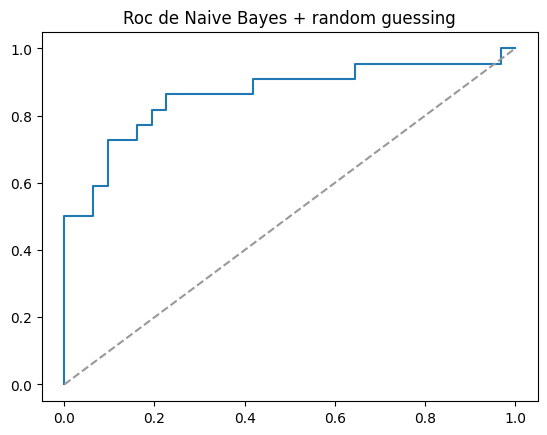

In [39]:
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test_nb, y_gnb_score[:, 1])
roc_auc_gnb=sk_metrics.auc(fpr_gnb,tpr_gnb)
plt.plot(fpr_gnb, tpr_gnb, label="ROC fold (area=%0.2f)"%(roc_auc_gnb))
plt.plot([0,1],[0,1],linestyle="--",color=(0.6,0.6,0.6),label="random guessing")
plt.title('Roc de Naive Bayes + random guessing')

Podemos ver que también esta curva Roc se acerca al 1, además vemos que claramente Naive Bayes ajusta mejor que "random guessing", por lo que lo preferimos y más adelante veremos quien de los cinco modelos es probablemente mejor.

Valor AUC de Naive Bayes:

In [52]:
print(trunc(roc_auc_gnb,3))

0.862


Aquí también vemos que el AUC está bastante bueno, ya que es un porcentaje del 86,2% por lo que se acerca al 1.

# **LDA**
El análisis discriminante linear (LDA) es un algoritmo de aprendizaje supervisado que se utiliza para tareas de clasificación en Machine Learning. Es una técnica utilizada para encontrar una combinación lineal de características que mejor separe las clases en un conjunto de datos.

---



In [57]:
y = df["attack"]
X = df.drop('attack',axis=1)

X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(
    X, y, test_size=0.20, random_state=123
)

Evaluamos el modelo:

In [58]:
lda = LDA()

lda.fit(X_train_lda, y_train_lda);

In [59]:
y_lda_score = lda.predict_proba(X_test_lda)

Curva ROC:

Text(0.5, 1.0, 'Roc de LDA + random guessing')

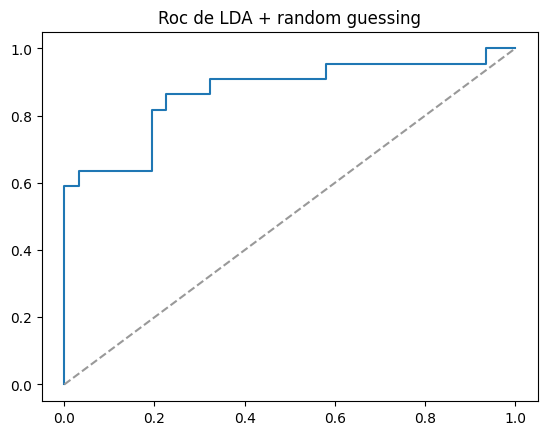

In [45]:
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_test_lda, y_lda_score[:, 1])
roc_auc_lda =sk_metrics.auc(fpr_lda,tpr_lda)
plt.plot(fpr_lda, tpr_lda, label="ROC fold (area=%0.2f)"%(roc_auc_lda))
plt.plot([0,1],[0,1],linestyle="--",color=(0.6,0.6,0.6),label="random guessing")
plt.title('Roc de LDA + random guessing')

De manera similar a las otras curvas ROC que hemos visto, esta también se ve buena, ya que, también está cercana al 1 y comparando con el experimento aleatorio, es claro que nos conviene quedarnos con el modelo LDA.

Valor AUC:

In [55]:
print(trunc(roc_auc_lda,3))

0.869


También vemos el valor del AUC del modelo LDA y concluimos que es muy bueno, se acerca casi a un pocentaje de 87%, que sería el más alto hasta ahora con respecto a los modelos ya vistos. Continuamos ahora con el QDA para finalizar y elegir un modelo.

# **QDA**
Al igual que LDA, el clasificador QDA asume que las observaciones de cada clase de Y se extraen de una distribución gaussiana. Sin embargo, a diferencia de LDA, QDA asume que cada clase tiene su propia matriz de covarianza.

---


In [60]:
y = df["attack"]
X = df.drop('attack',axis=1)

X_train_qda, X_test_qda, y_train_qda, y_test_qda = train_test_split(
    X, y, test_size=0.20, random_state=123
)

Evaluamos el modelo:

In [61]:
qda = QDA()
qda.fit(X_train_qda, y_train_qda)

QuadraticDiscriminantAnalysis()

In [62]:
y_score_qda = qda.predict_proba(X_test_qda)

Curva ROC:

Text(0.5, 1.0, 'Roc de QDA + random guessing')

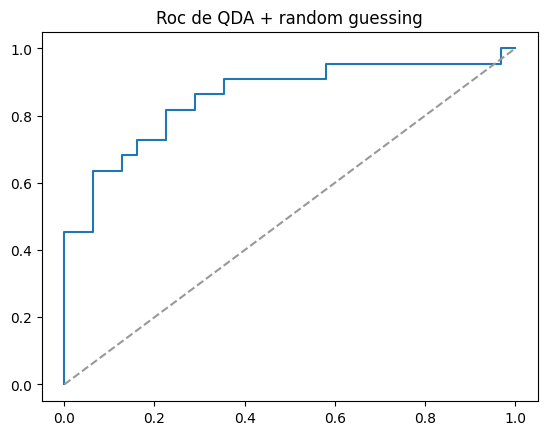

In [63]:
fpr_qda, tpr_qda, thresholds_qda = roc_curve(y_test_qda, y_score_qda[:, 1])
roc_auc_qda = sk_metrics.auc(fpr_qda,tpr_qda)
plt.plot(fpr_qda, tpr_qda, label="ROC fold (area=%0.2f)"%(roc_auc_qda))
plt.plot([0,1],[0,1],linestyle="--",color=(0.6,0.6,0.6),label="random guessing")
plt.title('Roc de QDA + random guessing')

Se ve una buena buena curva que se acerca al 1.
Notamos que ajusta mucho mejor que el experimento aleatorio, por lo que podemos decir que en realidad los cinco modelos implementados son mejores que el "random guessing", el cual a pesar de que sea más simple no estima tan bien como los modelos.

Valor AUC:

In [64]:
print(trunc(roc_auc_qda,3))

0.854


Aquí también vemos un buen AUC del 85,4%.

Observamos que tenemos buenos modelos, así que en lo que sigue veremos métricas para hacer la comparación entre los cinco y ver cual podríamos elegir como el mejor o más aceptable que los demás.

# **Métricas de desempeño**
A continuación veremos las métricas de desempeño de los cinco modelos.

Además del AUC, que ya ha sido mostrado en cada implementación de los modelos, veremos también el Accuracy y el F1-score:



*   AUC: es una métrica utilizada para evaluar el rendimiento de los modelos de aprendizaje automático de clasificación.


*   Accuracy (exactitud): es la proporción de predicciones correctas.


*   $F_1$ - score: es la media armónica de precisión y sensibilidad del test.


---



Implementación de métricas para añadir en nuestra tabla comparativa:

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)

y_pred_log = log.fit(X, y).predict(X_test_log)
y_pred_svm = svc.fit(X_train_svm, y_train_svm).predict(X_test_svm)
y_pred_nb = gnb.fit(X_train_nb, y_train_nb).predict(X_test_nb)
y_pred_lda = lda.fit(X_train_lda, y_train_lda).predict(X_test_lda)
y_pred_qda = qda.fit(X_train_qda, y_train_qda).predict(X_test_qda)

accuray_log = accuracy_score(y_pred_log, y_test_log)
f1_log = f1_score(y_pred_log, y_test_log, average="weighted")
accuray_svm = accuracy_score(y_pred_svm, y_test_svm)
f1_svm = f1_score(y_pred_svm, y_test_svm, average="weighted")
accuray_nb = accuracy_score(y_pred_nb, y_test_nb)
f1_nb = f1_score(y_pred_nb, y_test_nb, average="weighted")
accuray_lda = accuracy_score(y_pred_lda, y_test_lda)
f1_lda = f1_score(y_pred_lda, y_test_lda, average="weighted")
accuray_qda = accuracy_score(y_pred_qda, y_test_qda)
f1_qda = f1_score(y_pred_qda, y_test_qda, average="weighted")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# **Tabla comparativa**

Aquí se realiza una tabla de comparaciones de algunas métricas de desempeño de los modelos trabajados.

In [ ]:
d = [ ["LG", roc_auc_log, accuray_log, f1_log],
     ["SVM", roc_auc_svm, accuray_svm, f1_svm],
     ["GNB", roc_auc_gnb, accuray_nb, f1_nb],
     ["LDA", roc_auc_lda, accuray_lda, f1_lda],
     ["QDA", roc_auc_qda, accuray_qda, f1_qda]]

print ("{:<8} {:<10}   {:<20}  {:<30}".format('Modelo','AUC','        Accuracy','        F1'))

for v in d:
    Modelo, AUC, Accuracy, F1= v
    print ("{:<8} {:<10}   {:<20}  {:<30}".format( Modelo, AUC, Accuracy, F1))

Modelo   AUC                  Accuracy              F1                    
LG       0.8484848484848484   0.6981132075471698    0.6941293642450064            
SVM      0.8530303030303031   0.7924528301886793    0.7935648318639026            
GNB      0.8621700879765396   0.8113207547169812    0.8150371640937679            
LDA      0.8695014662756598   0.8301886792452831    0.837638294570206             
QDA      0.8548387096774194   0.7924528301886793    0.7952564692555489            


# **Conclusión**

De la información recopilada a lo largo de este trabajo podemos notar que el modelo LDA es el que mejor se ve en término de las medidas AUC, Accuracy y F1.

 En los tres casos el LDA toma los valores más grandes entre los cinco modelos trabajados y además son muy cercanos al 1. Por lo tanto podríamos decir que el mejor con respecto a las mediciones es el modelo LDA, sin embargo no podemos descartar los otros cuatro rotundamente, ya que, los valores que toman en las mediciones de la tabla vista anteriormente también son cercanos al 1.

 Para poder definitivamente escoger uno, tendríamos que comparar también el tamaño de los datos que estamos tomando como training; probar con varios valores y ahí tendríamos una perspectiva más amplia y podríamos tomar una mejor decisión. Pero para esta oportunidad diremos que el mejor (sin menospreciar la exactitud de los otros) sería el modelo Linear Discrimination Analysis.